### In this project, we will do model comparison on four Dark Matter density profiles. We will test which models fits the galaxy rotational curve best.

### Model
Model 

$ M $ = The rotational curve calculated with the existence of dark matter and the dark matter density is given by the density profile. We have four dark matter density files and give us 4 models to compare. 

The posterior distribution is calculated as, $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $



### The four Dark Matter density profiles models: 

Note that

r: galactocentric radius

$ \rho( r ) $ : Dark Matter Density as a function of galactocentric radius


### (1) NFW profile :

 $ \rho \left( r \right) \propto \frac{1}{{\left( r/a \right)}{\left[ 1~+~{{\left( r/a \right)}} \right]}^{2}} $


### (2) Isothermal profile:

  $  \rho \left( r \right) \propto \frac{1}{{\left[ 1~+~{{\left( r/a \right)}^{2}} \right]}} $


### (3) Einasto profile :

 $ \rho \left( r \right) \propto \exp^{- A r ^\alpha} $


### (4) Generalized DM profile :

 $ \rho \left( r \right) \propto    \frac{1}{{\left( r/a \right)}^{\gamma}{\left[ 1~+~{{\left( r/a \right)}^{\alpha}} \right]}^{ \frac{(\beta - \gamma)}{\alpha}}} $



### We can calcuate rotational curve from Dark Matter density profiles, by assuming dark matter distribution is spherically symmetric

$ \frac{GMm}{4 \pi  R^2} = \frac {m v^2}{R}$  where $M=\int_{R_o}^{R} \rho (r) 4 \pi  R^2 dr$

$v_{calculated} = \sqrt { \frac{ G   \int_{R_o}^{R} \rho (r) 4 \pi  r^2 dr} {4 \pi  r}  }   $

In [87]:
  #  !!!! pip install nestle  (from terminal)
    
# !conda install -y -c conda-forge nestle (somehow couldn't find nestle)

In [1]:
import numpy as np
import nestle
import math

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import corner

from scipy.integrate import quad

from nsdmd import model 
from nsdmd import dmdio

In [9]:
data_x,data_xerr,data_y,data_yerr = dmdio.load_data('example_data.txt')

/Users/june/NestedSampling_DMD/NestedSampling_DMD/nsdmd/dmdio.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataExp =pd.read_csv(data_file, sep=', ', header=None,names=['r','v','dv'])


Our raw data are obtained from Bhattacharjee et. al. 2014, Rotation Curve of the Milky Way out to ∼200 kpc (https://arxiv.org/abs/1310.2659)### The data will be used in this project is the measured rotational speed of the interstellar medium in our local galaxy, as shown in the following figure. 

In [10]:
plt.figure()
plt.errorbar(data_x,data_y,data_yerr,data_xerr,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius")
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'int'

### The log likelihood is meant to capture how well a model is able to reproduce the data that it is meant to simulate.

$log p(D|M, I) = constant* \prod_{i}^{} log(\sigma_i)  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

$constant* \prod_{i}^{} log(\sigma_i) $, this part doesn't matter much since they are the same for all. 

$log p(D|M, I) =  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

In [91]:
# Define model
def model_NFW(theta, x):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    #
    # Note: the mass defined here does not include the normalization constant rho0 (kg/kpc^3).
    # The units of a are kpc.
    # The units of the "mass" calculated here are thus kpc^3.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+x)/a)-x/(a+x))
        
    # Calculate the rotation velocity: vrot = theta[1]*sqrt(mass/x)
    # The units of sqrt(mass/x) are kpc.
    # The rotation velocity is equal to sqrt(G*rho0)*sqrt((M/rho0)/x) where M is the mass enclosed, 
    # rho0 is the normalization constant of the mass distribution, and x is the distance at which we
    # calculate vrot.
    # When we determine theta[1], we determine sqrt(G*rho0).
    # The units of vrot are km/s.
    # The units of sqrt(mass/x) are kpc.
    # The units of theta[1] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.
    # Since theta[1] = sqrt(G*rho0) we can now determine rho0: rho0 = theta[1]^2/G.
    # The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3)
    # To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3
    # The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 * ((3.24E-17)^2 * (3.086E19)^3 kg/(kpc)^3 = 
    # (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.
    vrot = theta[1]*np.sqrt(mass/x) 
    
    return vrot

In [92]:
# Define a likelihood function
def loglike_NFW(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+data_x)/a-data_x/(a+data_x)))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x) 
    
    # The y variable is the rotational velocity.
    y = vrot

    # Calculate chisq
    chisq= np.sum(((data_y - y) / data_yerr)**2)
    return -chisq / 2.



### The prior: 
uniform priors with constraints from literature. 
  

In [93]:
# It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest. 
# 


def prior_transform_NFW(theta):
    
    # theta[0] in the range of [0,10] and theta[1] in the range of [0,300]
    # return  np.array([10, 300]) * theta
    return  np.array([10*theta[0],500*theta[1]])


Therefore, we can calculated the posterior $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $ and compare the posterior by MCMC and/or Nestle to do model comparison. 

By using the Nestle package, it will give us log evidence, numerical (sampling) error on logz, array of sample parameters, array of weights associated with each sampleand result.weights. 

In [94]:
# Run nested sampling.
result = nestle.sample(loglike_NFW, prior_transform_NFW, 2)

print ('log evidence')
print (result.logz)

print ('numerical (sampling) error on logz')
print (result.logzerr)   
       
print ('array of sample parameters')
print (result.samples)  
       
print ('array of weights associated with each sample')
print (result.weights)


log evidence
-49.2344879067
numerical (sampling) error on logz
0.261013328151
array of sample parameters
[[   9.52258066  490.33532233]
 [   9.65912151  403.00478683]
 [   9.20280593  419.00792852]
 ..., 
 [   2.59451038   47.3038859 ]
 [   2.35096508   53.55544642]
 [   2.10495199   61.66699495]]
array of weights associated with each sample
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000

core radius a =  2.14 +/-  0.62 kpc
normalization factor = 70.62 +/- 34.06
Halo density normalization constant = 1.63e+07 +/- 7.87e+06 Msun/kpc^3
Halo density in our solor system = 5.60e+07 Msun/kpc^3.
Halo density in our solor system = 2.14e+03 GeV/c^2/liter.


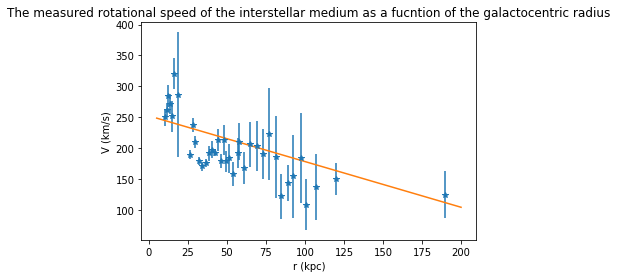

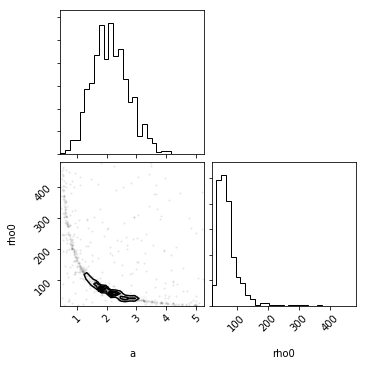

In [95]:
data_xerr = 0
p, cov = nestle.mean_and_cov(result.samples, result.weights)

print("core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p[0], np.sqrt(cov[0, 0])))
print("normalization factor = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p[1], 2.312E5*np.sqrt(cov[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p, 8)))

plt.figure()
plt.errorbar(data_x,data_y,data_yerr,data_xerr,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius")
plt.plot([5.,200.],model_NFW(p, np.array([5.,200.])))
plt.show()

fig = corner.corner(result.samples, weights=result.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()